# Objectives

# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import faiss

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score, precision_score


# Dataset

In [ ]:
df_balanced = pd.read_csv('..\Datasets\FINAL.csv', low_memory=False)

In [4]:
display(df_balanced)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,0,0,117271,65,65.0,Heart Rate,Routine Vital Signs,10.216667,2724,EW EMER.,WHITE,87,12.40,K/uL,STAT,4.933333,0,0.0,0.00,0.0
1,1,1,164988,Some resistance,4.0,Strength R Arm,Neurological,2.600000,2724,EW EMER.,WHITE,87,25.70,sec,STAT,4.933333,0,0.0,0.00,0.0
2,2,2,164461,100,100.0,O2 saturation pulseoxymetry,Respiratory,0.000000,2724,URGENT,UNKNOWN,88,3.40,m/uL,ROUTINE,23.250000,0,0.0,0.00,0.0
3,3,3,128539,0.9,0.9,Creatinine (serum),Labs,4.150000,2724,EW EMER.,WHITE,56,105.00,mEq/L,ROUTINE,4.150000,0,28.3,67.00,180.4
4,4,4,21639,3.6,3.6,Potassium (whole blood),Labs,9.500000,2724,ELECTIVE,WHITE,70,1.15,mmol/L,Unknown,15.666667,0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,65995,65995,275391,1,1.0,PICC Line Dressing Occlusive,Access Lines - Invasive,23.683333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,13.20,K/uL,ROUTINE,19.550000,0,18.9,62.50,105.0
65996,65996,65996,261802,24,24.0,HCO3 (serum),Labs,18.650000,E039,EW EMER.,WHITE,72,28.00,%,ROUTINE,14.200000,0,0.0,63.25,0.0
65997,65997,65997,284264,0 Alert and calm,0.0,Richmond-RAS Scale,Pain/Sedation,23.683333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,141.00,mEq/L,ROUTINE,13.533333,0,18.9,62.50,105.0
65998,65998,65998,276005,4 - Chair - Transfer to chair/bed,4.0,Activity / Mobility (JH-HLM),Treatments,9.900000,E039,EW EMER.,WHITE,32,7.80,mg/dL,ROUTINE,17.400000,0,25.1,65.00,152.0


In [5]:
df_balanced = df_balanced.drop(columns=['Unnamed: 0.1', 'Unnamed: 0.2'])

# Treatment Pipeline

In [6]:
df_balanced = df_balanced.copy()

In [7]:
class Treatment(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()
        self.variables_cat = ['priority']
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.encoder.fit(df[self.variables_cat])
        self.ohe_columns = self.encoder.get_feature_names_out(self.variables_cat)

        self.label_encoders = {}
        variables_label = ['icd_code', 'category', 'race', 'lab_value_unit']
        
        for col in variables_label:
            if col in df.columns:
                le = LabelEncoder()
                le.fit(df[col].astype(str))
                self.label_encoders[col] = le

        return self

    def transform(self, X):
        df = X.copy()

        # Feature Interactions
        urgency_rank = {
            'Unknown': 0, 'ELECTIVE': 1, 'OBSERVATION ADMIT': 2,
            'SURGICAL SAME DAY ADMISSION': 3, 'URGENT': 4,
            'DIRECT EMER.': 5, 'EW EMER.': 6
        }
        
        if 'admission_type' in df.columns:
            df['urgency_score'] = df['admission_type'].map(urgency_rank)
            df['urgency_x_lab_delay'] = df['urgency_score'] * df['time_since_admission_labevent']
            df['admission_x_age'] = df['urgency_score'] * df['age']
            # Drop da variável original
            df.drop(columns=['admission_type'], inplace=True)

        # OneHotEncoding
        one_hot_encoded = self.encoder.transform(df[self.variables_cat])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.ohe_columns, index=df.index)
        df = pd.concat([df.drop(columns=self.variables_cat), one_hot_df], axis=1)

        # LabelEncoding 
        for col, le in self.label_encoders.items():
            if col in df.columns:
                df[col] = le.transform(df[col].astype(str))
            else:
                print(f"Aviso: Coluna '{col}' não encontrada em transform().")

        # Frequency encoding
        if 'value_chart' in df.columns:
            df['value_chart'] = df['value_chart'].astype(str)
            df['value_chart_freq'] = df['value_chart'].map(df['value_chart'].value_counts())
            df.drop(columns=['value_chart'], inplace=True)

        if 'chart_label' in df.columns:
            df['chart_label'] = df['chart_label'].astype(str)
            df['chart_label_freq'] = df['chart_label'].map(df['chart_label'].value_counts())
            df.drop(columns=['chart_label'], inplace=True)

        return df


In [8]:

le = LabelEncoder()
y = le.fit_transform(df_balanced['icd_code'])
X = df_balanced.drop('icd_code', axis=1)

In [9]:
print(le.classes_)
joblib.dump(le, 'label_encoder_icd.pkl')

['2724' '4019' 'E039' 'E785' 'Z794' 'Z87891']


['label_encoder_icd.pkl']

In [10]:
treatment = Treatment()
X_processed = treatment.fit_transform(X)
joblib.dump(treatment, 'treatment.pkl')
X_processed.shape 

(66000, 21)

# FAISS INDEX

## L2 Index - Euclidean distance

In [11]:
n_features = 21

# simplest indlex - Euclidean distante
indexL2 = faiss.IndexFlatL2(n_features)

In [12]:
indexL2.is_trained

True

In [13]:
indexL2.add(X_processed.astype('float32'))

In [14]:
indexL2.ntotal

66000

## Cosine Similarity Index

In [15]:
X_vec = np.ascontiguousarray(X_processed.to_numpy().astype('float32'))
faiss.normalize_L2(X_vec)
index_cosine = faiss.IndexFlatIP(X_vec.shape[1])
index_cosine.add(X_vec)

print("Total vectors added:", index_cosine.ntotal)


Total vectors added: 66000


## HNSW Index


In [16]:
index_hnsw = faiss.IndexHNSWFlat(n_features, 32)  # 32 = número de conexões por nó
index_hnsw.add(X_processed.astype('float32'))

In [17]:
index_hnsw.ntotal

66000

## Locality-Sensitive Hashing Index

In [18]:
n_bits = 128
index_lsh = faiss.IndexLSH(n_features, n_bits)
index_lsh.add(X_processed.astype('float32'))

In [19]:
index_lsh.ntotal

66000

# XGBoost Model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.33, random_state=42)

In [21]:

param_dist = {
    'model__max_depth': [6,8],
    'model__learning_rate': [0.05, 0.1],
    'model__gamma': [0, 0.5],
    'model__min_child_weight': [1, 3],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 2],
    'model__n_estimators': [100, 150]  
}


pipeline = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        tree_method='hist',
        eval_metric='mlogloss',
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    ))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_dist,
    scoring='precision_weighted',
    cv=5, # Cross Validation
    n_jobs=-1,
    verbose=2 )

In [22]:

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:40:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=6, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 0.5],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [6, 8],
                         'model__min_child_weight': [1, 3],
                         'model__n_estimators': [100, 150],
                         'model__reg_alpha': [0, 0.1],
                         'model__reg_lambda': [1, 2]},
             scoring='precision_weighted', verbose=2)

In [23]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__gamma': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 150, 'model__reg_alpha': 0, 'model__reg_lambda': 1}
0.9983062529830253


# Evaluation Metrics

In [24]:

y_pred = grid_search.predict(X_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print("Accuracy - Internal validation:", grid_search.best_score_)

print("\nAccuracy - Real", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 99.79%
Accuracy - Internal validation: 0.9983062529830253

Accuracy - Real 0.9978879706152434
Precision (macro): 0.9978899312425117

Classification Report:
               precision    recall  f1-score   support

        2724       0.99      1.00      1.00      3630
        4019       1.00      0.99      1.00      3630
        E039       1.00      1.00      1.00      3630
        E785       1.00      1.00      1.00      3630
        Z794       1.00      1.00      1.00      3630
      Z87891       1.00      1.00      1.00      3630

    accuracy                           1.00     21780
   macro avg       1.00      1.00      1.00     21780
weighted avg       1.00      1.00      1.00     21780



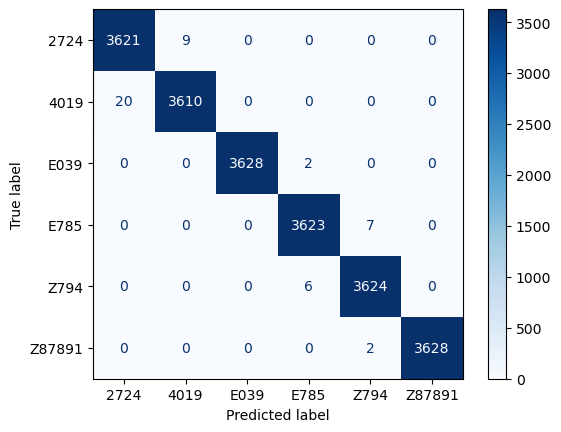

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues') 

In [26]:

joblib.dump(grid_search.best_estimator_, 'modelo_pipeline_final.pkl')

['modelo_pipeline_final.pkl']

## Overfit Check

In [27]:
from sklearn.metrics import accuracy_score, f1_score

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("Accuracy treino:", accuracy_score(y_train, y_train_pred))
print("Accuracy teste:", accuracy_score(y_test, y_test_pred))
print("F1 treino:", f1_score(y_train, y_train_pred, average='macro'))
print("F1 teste:", f1_score(y_test, y_test_pred, average='macro'))

Accuracy treino: 0.9997060153776571
Accuracy teste: 0.9978879706152434
F1 treino: 0.9997060153733898
F1 teste: 0.9978881319154275


### Download 

In [28]:
treatment = joblib.load('treatment.pkl')
pipeline = joblib.load('modelo_pipeline_final.pkl')
le = joblib.load('label_encoder_icd.pkl')

In [29]:
faiss.write_index(indexL2, 'faiss_index_L2.bin')
faiss_index = faiss.read_index('faiss_index_L2.bin')

faiss.write_index(index_cosine, 'faiss_index_Cosine.bin')
faiss_index_cosine = faiss.read_index('faiss_index_Cosine.bin')

faiss.write_index(index_hnsw, 'faiss_index_HNSW.bin')
faiss_index_hnsw = faiss.read_index('faiss_index_HNSW.bin')

faiss.write_index(index_lsh, 'faiss_index_LSH.bin')
faiss_index_lsh = faiss.read_index('faiss_index_LSH.bin')


# New Cases

In [ ]:
new_cases = pd.read_csv('..\Datasets\cases_shuffled.csv', low_memory=False)

In [ ]:
lable = pd.read_csv('..\Datasets\icd_match.csv')

In [32]:
display(new_cases)

,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,267004,10.5,10.5,Hemoglobin,Labs,13.533333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,231.00,IU/L,STAT,2.916667,0,18.9,62.50,105.0
1,269677,Yes,25.0,History of falling (within 3 mnths),Restraint/Support Systems,15.683333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,2.40,mg/dL,ROUTINE,13.533333,0,18.9,62.50,105.0
2,137172,2,2.0,O2 Flow,Respiratory,2.216667,2724,EW EMER.,WHITE,87,99.00,fL,STAT,4.933333,0,0.0,0.00,0.0
3,287169,0,0.0,Sexuality / reproductive problems,Adm History/FHPA,0.383333,E039,URGENT,WHITE,86,7.70,mg/dL,ROUTINE,1.616667,0,0.0,0.00,0.0
4,93531,14,14.0,Respiratory Rate,Respiratory,18.283333,4019,DIRECT EMER.,WHITE,67,4.36,m/uL,STAT,15.783333,0,0.0,0.00,239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,431957,24,24.0,Respiratory Rate,Respiratory,4.583333,Z87891,EW EMER.,WHITE,70,30.10,pg,STAT,3.850000,0,33.2,63.25,187.6
116,171064,Full resistance,5.0,Strength R Arm,Neurological,2.150000,2724,EW EMER.,WHITE,91,6.00,units,STAT,18.150000,0,0.0,0.00,0.0
117,385732,8,8.0,Resp Alarm - Low,Alarms,3.000000,Z794,EW EMER.,WHITE,32,12.00,mEq/L,STAT,21.700000,0,25.1,65.00,152.0
118,265042,138,138.0,Sodium (serum),Labs,16.483333,E039,OBSERVATION ADMIT,WHITE,69,86.00,mm Hg,Unknown,17.200000,0,0.0,66.00,0.0


In [33]:
case = treatment.transform(new_cases)

expected_cols = pipeline.named_steps['model'].feature_names_in_
missing_cols = set(expected_cols) - set(case.columns)

print("Missing columns:")
print(missing_cols)

Missing columns:
set()


In [34]:
case_features = case.drop(columns=['icd_code'], errors='ignore')
preds = pipeline.predict(case_features)
print(preds)

[2 2 0 2 1 3 3 0 2 5 0 3 0 1 4 4 5 0 4 5 3 2 1 3 2 0 0 5 3 4 1 3 1 4 2 5 1
 2 5 0 1 1 3 1 4 4 0 4 3 1 2 1 0 3 1 5 0 2 3 3 4 1 0 4 5 0 0 4 0 0 1 5 0 3
 5 4 2 2 4 2 4 3 5 3 4 2 2 2 5 2 3 1 5 2 3 5 1 1 5 0 2 1 0 1 5 4 4 5 3 4 4
 5 1 3 3 5 0 4 2 5]


In [35]:
icd_dict = dict(zip(lable['icd_code'], lable['long_title']))

In [36]:

predicted_icd_codes = le.inverse_transform(preds)
for i, (index, row) in enumerate(new_cases.iterrows()):
    icd_code = predicted_icd_codes[i]
    description = icd_dict.get(icd_code)
    
    print(f"Case {i+1}:")
    print(row.to_dict())  
    print(f"Diagnosis Result: {icd_code} - {description}")
    print("-" * 40)


Case 1:
{'Unnamed: 0': 267004, 'value_chart': '10.5', 'valuenum_chartevent': 10.5, 'chart_label': 'Hemoglobin', 'category': 'Labs', 'time_since_admission_chartevent': 13.533333333333331, 'icd_code': 'E039', 'admission_type': 'EW EMER.', 'race': 'BLACK/AFRICAN AMERICAN', 'age': 48, 'lab_results': 231.0, 'lab_value_unit': 'IU/L', 'priority': 'STAT', 'time_since_admission_labevent': 2.9166666666666665, 'death': 0, 'BMI (kg/m2)': 18.9, 'Height (Inches)': 62.5, 'Weight (Lbs)': 105.0}
Diagnosis Result: E039 - Hypothyroidism, unspecified
----------------------------------------
Case 2:
{'Unnamed: 0': 269677, 'value_chart': 'Yes', 'valuenum_chartevent': 25.0, 'chart_label': 'History of falling (within 3 mnths)', 'category': 'Restraint/Support Systems', 'time_since_admission_chartevent': 15.683333333333334, 'icd_code': 'E039', 'admission_type': 'EW EMER.', 'race': 'BLACK/AFRICAN AMERICAN', 'age': 48, 'lab_results': 2.4, 'lab_value_unit': 'mg/dL', 'priority': 'ROUTINE', 'time_since_admission_lab

In [37]:
preds_labels = le.inverse_transform(preds)
comparison = pd.DataFrame({
    'Real': case['icd_code'] if 'icd_code' in case.columns else pd.Series([None]*len(case)),
    'Predicted': preds_labels
})

pd.set_option('display.max_rows', None)      
pd.set_option('display.max_columns', None)   
pd.set_option('display.width', None)         
pd.set_option('display.max_colwidth', None)

display(comparison.head(20))

,Real,Predicted
0,E039,E039
1,E039,E039
2,2724,2724
3,E039,E039
4,4019,4019
5,E785,E785
6,E785,E785
7,2724,2724
8,E039,E039
9,Z87891,Z87891


# Vector Search FAISS

In [38]:

indexes = [
    ('L2', faiss_index),
    ('Cosine', faiss_index_cosine),
    ('HNSW', faiss_index_hnsw),
    ('LSH', faiss_index_lsh)
]

In [39]:
import pandas as pd
import numpy as np
import time

# number of neighbors
k = 3  

query_vectors = case.drop(columns=['icd_code'], errors='ignore').astype('float32')
query_vectors = np.ascontiguousarray(query_vectors)

if len(query_vectors.shape) == 1:
    query_vectors = query_vectors.reshape(1, -1)

indexes = [
    ('L2', faiss_index),
    ('Cosine', faiss_index_cosine),
    ('HNSW', faiss_index_hnsw),
    ('LSH', faiss_index_lsh)
]

all_neighbors = []

for name, idx in indexes:
    start = time.time()
    D, I = idx.search(query_vectors, k)
    end = time.time()
    
    print(f"\n=== Index: {name} ===")
    print(f"Time taken: {(end - start) * 1000:.4f} ms")
    
    for case_idx, (neighbors, distances) in enumerate(zip(I, D)):
        for rank, (neighbor_idx, dist) in enumerate(zip(neighbors, distances), 1):
            row = df_balanced.iloc[neighbor_idx].copy()  
            row['query_case'] = case_idx      
            row['neighbor_rank'] = rank         
            row['distance'] = dist              
            row['index_type'] = name            
            all_neighbors.append(row)

neighbors_df = pd.DataFrame(all_neighbors)
display(neighbors_df)



=== Index: L2 ===
Time taken: 134.9931 ms

=== Index: Cosine ===
Time taken: 55.8162 ms

=== Index: HNSW ===
Time taken: 9.8195 ms

=== Index: LSH ===
Time taken: 44.7862 ms


,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs),query_case,neighbor_rank,distance,index_type
55522,266991,1.02,1.020,Specific Gravity (urine),Labs,3.433333,E039,EW EMER.,WHITE,60,89.000,fL,STAT,6.283333,0,37.1,71.50,277.20,0,1,1.638400e+04,L2
61093,267286,Normal Activity,0.000,Agitation,Toxicology,3.683333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,166.000,K/uL,ROUTINE,7.533333,0,18.9,62.50,105.00,0,2,6.553600e+04,L2
58246,266913,1.16,1.160,Ionized Calcium,Labs,20.583333,E039,EW EMER.,WHITE,70,7.000,#/hpf,ROUTINE,14.650000,0,33.2,63.25,187.60,0,3,1.146880e+05,L2
56670,269692,5.56,5.560,Cardiac Output (thermodilution),Hemodynamics,14.750000,E039,SURGICAL SAME DAY ADMISSION,WHITE,72,0.000,mEq/L,Unknown,13.433333,0,0.0,70.00,0.00,1,1,1.638400e+04,L2
61813,269882,0.2,0.200,Differential-Basos,Labs,1.616667,E039,URGENT,WHITE,86,0.200,%,ROUTINE,15.283333,0,0.0,0.00,0.00,1,2,3.276800e+04,L2
64091,269773,33,33.000,Venous CO2 Pressure,Labs,12.766667,E039,EW EMER.,WHITE,32,30.000,mm Hg,Unknown,9.916667,0,25.1,65.00,152.00,1,3,3.276800e+04,L2
7786,137157,25.7,25.700,PTT,Labs,4.933333,2724,EW EMER.,WHITE,87,102.000,mEq/L,STAT,4.933333,0,0.0,0.00,0.00,2,1,5.734400e+04,L2
187,137146,0.9,0.900,Inspiratory Time,Respiratory,2.866667,2724,EW EMER.,OTHER,64,9.100,K/uL,ROUTINE,10.766667,0,0.0,0.00,0.00,2,2,7.372800e+04,L2
6137,137114,1.3,1.300,INR,Labs,0.050000,2724,URGENT,UNKNOWN,88,26.500,sec,ROUTINE,23.250000,0,0.0,0.00,0.00,2,3,9.830400e+04,L2
59364,287184,58,58.000,PA Line cm Mark,Hemodynamics,11.166667,E039,SURGICAL SAME DAY ADMISSION,WHITE,72,32.000,mEq/L,Unknown,16.300000,0,0.0,70.00,0.00,3,1,8.192000e+04,L2


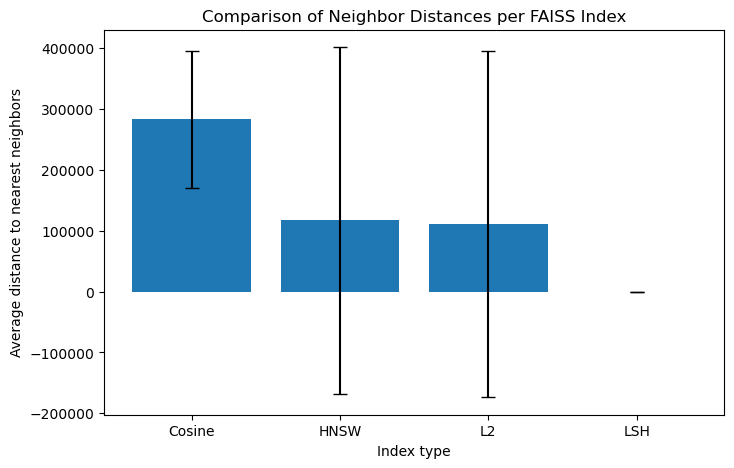

In [40]:
import matplotlib.pyplot as plt

# Agrupa por índice e calcula média e desvio das distâncias
summary = neighbors_df.groupby('index_type')['distance'].agg(['mean','std']).reset_index()

plt.figure(figsize=(8,5))
plt.bar(summary['index_type'], summary['mean'], yerr=summary['std'], capsize=5)
plt.ylabel('Average distance to nearest neighbors')
plt.xlabel('Index type')
plt.title('Comparison of Neighbor Distances per FAISS Index')
plt.show()


In [41]:
# Filtrar apenas os vizinhos do caso 0
case1_neighbors = neighbors_df[neighbors_df['query_case'] == 1].copy()

# Mostrar o resultado
display(case1_neighbors)

,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs),query_case,neighbor_rank,distance,index_type
56670,269692,5.56,5.56,Cardiac Output (thermodilution),Hemodynamics,14.750000,E039,SURGICAL SAME DAY ADMISSION,WHITE,72,0.0,mEq/L,Unknown,13.433333,0,0.0,70.00,0.00,1,1,16384.000000,L2
61813,269882,0.2,0.20,Differential-Basos,Labs,1.616667,E039,URGENT,WHITE,86,0.2,%,ROUTINE,15.283333,0,0.0,0.00,0.00,1,2,32768.000000,L2
64091,269773,33,33.00,Venous CO2 Pressure,Labs,12.766667,E039,EW EMER.,WHITE,32,30.0,mm Hg,Unknown,9.916667,0,25.1,65.00,152.00,1,3,32768.000000,L2
29452,441738,39.1,39.10,Flow Rate (L/min),Respiratory,6.433333,Z87891,EW EMER.,UNKNOWN,79,31.8,sec,STAT,4.750000,0,33.3,62.00,181.88,1,1,269677.218750,Cosine
23599,434615,0.5,0.50,Direct Bilirubin,Labs,6.000000,Z87891,EW EMER.,WHITE,72,15.0,K/uL,STAT,23.233333,0,0.0,63.25,0.00,1,2,269677.218750,Cosine
20635,198143,No Anxiety,0.00,Anxiety,Toxicology,8.700000,4019,EW EMER.,WHITE,34,35.0,mm Hg,Unknown,19.350000,0,0.0,0.00,0.00,1,3,269677.218750,Cosine
56670,269692,5.56,5.56,Cardiac Output (thermodilution),Hemodynamics,14.750000,E039,SURGICAL SAME DAY ADMISSION,WHITE,72,0.0,mEq/L,Unknown,13.433333,0,0.0,70.00,0.00,1,1,20718.824219,HNSW
64091,269773,33,33.00,Venous CO2 Pressure,Labs,12.766667,E039,EW EMER.,WHITE,32,30.0,mm Hg,Unknown,9.916667,0,25.1,65.00,152.00,1,2,40258.925781,HNSW
56090,269636,1.2,1.20,Ionized Calcium,Labs,2.883333,E039,EW EMER.,WHITE,32,12.0,K/uL,ROUTINE,17.400000,0,25.1,65.00,152.00,1,3,48919.320312,HNSW
0,117271,65,65.00,Heart Rate,Routine Vital Signs,10.216667,2724,EW EMER.,WHITE,87,12.4,K/uL,STAT,4.933333,0,0.0,0.00,0.00,1,1,0.000000,LSH


In [42]:
# Selecionar o caso 0 no conjunto de novos casos
case_1 = case.iloc[1]  # primeira linha
print("Query case 0:")
display(case_1)

# Verificar ICD do caso
icd_case0 = case_1.get('icd_code', 'N/A')
print("ICD code do caso 0:", icd_case0)

Query case 0:


Unnamed: 0                            269677
valuenum_chartevent                     25.0
category                                  16
time_since_admission_chartevent    15.683333
icd_code                                E039
race                                       0
age                                       48
lab_results                              2.4
lab_value_unit                            15
time_since_admission_labevent      13.533333
death                                      0
BMI (kg/m2)                             18.9
Height (Inches)                         62.5
Weight (Lbs)                           105.0
urgency_score                              6
urgency_x_lab_delay                     81.2
admission_x_age                          288
priority_ROUTINE                         1.0
priority_STAT                            0.0
priority_Unknown                         0.0
value_chart_freq                           2
chart_label_freq                           2
Name: 1, d

ICD code do caso 0: E039


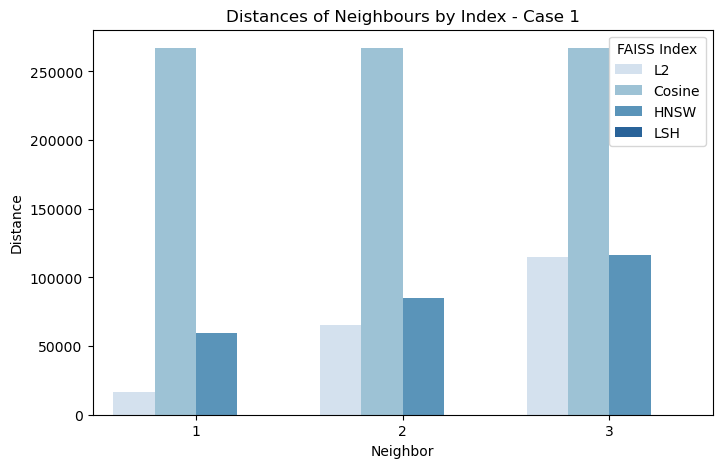

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

neighbors_case1 = neighbors_df[neighbors_df['query_case'] == 0]

plt.figure(figsize=(8,5))
sns.barplot(
    x='neighbor_rank', 
    y='distance', 
    hue='index_type', 
    data=neighbors_case1,
    palette='Blues'
)
plt.title('Distances of Neighbours by Index - Case 1')
plt.xlabel('Neighbor')
plt.ylabel('Distance')
plt.legend(title='FAISS Index')
plt.show()


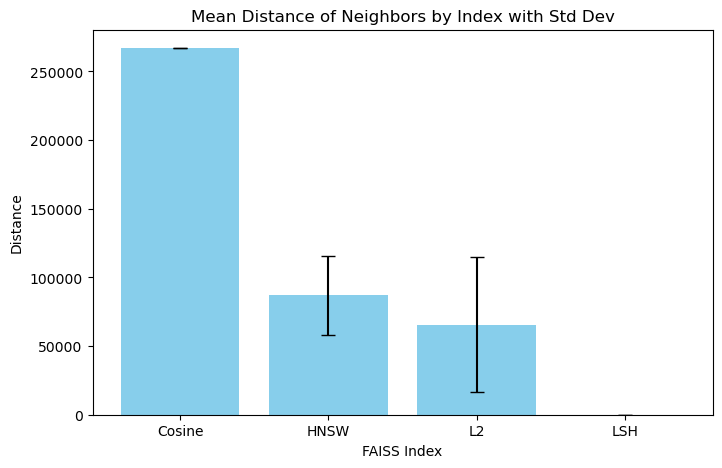

  index_type           mean           std            min            max
0     Cosine  267004.291667      0.018042  267004.281250  267004.312500
1       HNSW   86900.932292  28767.193085   59179.335938  116610.585938
2         L2   65536.000000  49152.000000   16384.000000  114688.000000
3        LSH       0.000000      0.000000       0.000000       0.000000


In [44]:

summary_stats = neighbors_case1.groupby('index_type')['distance'].agg(['mean', 'std', 'min', 'max']).reset_index()

plt.figure(figsize=(8,5))
plt.bar(summary_stats['index_type'], summary_stats['mean'], yerr=summary_stats['std'], capsize=5, color='skyblue')
plt.title('Mean Distance of Neighbors by Index with Std Dev')
plt.ylabel('Distance')
plt.xlabel('FAISS Index')
plt.show()

print(summary_stats)
